In [5]:
import torch
print(torch.__version__)

1.9.1


In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import os.path as osp
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [8]:
df = pd.read_csv("../input/cancer-detection/train_labels.csv")
len(df)

220025

In [9]:
df[df.duplicated(keep=False)]
len(df)

220025

In [10]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Custom Image Dataset

In [11]:
train_path = '../input/cancer-detection/train'
test_path = '../input/cancer-detection/test'

from sklearn.model_selection import train_test_split

train, val = train_test_split(df, 
                              stratify=df.label, 
                              test_size=0.2)

print("train size: ", len(train))
print("test size: ", len(val))

train size:  176020
test size:  44005


In [12]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        super().__init__()
        self.df = df.values
        self.image_dir = image_dir
        self.transform = transform
    
    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.image_dir, img_name + '.tif')
        
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
    
    def __len__(self):
        return len(self.df)
        

In [13]:
transform = T.Compose([T.Resize(32),
                      T.RandomHorizontalFlip(p=0.5),
                      T.ToTensor(),
                      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
def imshow(image, label):
    label = str(label)
    plt.figure(figsize=(5, 5))
    plt.title("label: " + label)
    print(image.shape)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

In [15]:
128//2

64

torch.Size([3, 32, 32])


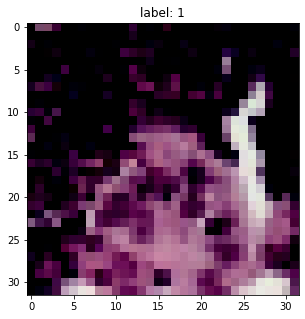

In [17]:
train_path = '../input/cancer-detection/train'

train_img = ImageDataset(df=train, image_dir=train_path, transform=transform)
val_img = ImageDataset(df=val, image_dir=train_path, transform=transform)

train_loader = DataLoader(dataset=train_img, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_img, batch_size=64, shuffle=False)

image, label = val_img[110]
imshow(image, label)

### CNN

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        
        # batch = 128
        super(Net, self).__init__()
        
        # Conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16)
        
        # FC layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.sigmoid = nn.Sigmoid()
        
        self.norm_fc1 = nn.BatchNorm1d(120)
        self.norm_fc2 = nn.BatchNorm1d(84)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.norm1(x)
        
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = self.norm2(x)
        
        # image flatten for FC
        x = x.view(-1, 16 * 5 * 5)
        
        x = self.norm_fc1(F.relu(self.fc1(x)))
        x = self.norm_fc2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
        
        

In [48]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
            Conv2d-4           [-1, 16, 10, 10]           2,416
         MaxPool2d-5             [-1, 16, 5, 5]               0
       BatchNorm2d-6             [-1, 16, 5, 5]              32
            Linear-7                  [-1, 120]          48,120
       BatchNorm1d-8                  [-1, 120]             240
            Linear-9                   [-1, 84]          10,164
      BatchNorm1d-10                   [-1, 84]             168
           Linear-11                    [-1, 2]             170
Total params: 61,778
Trainable params: 61,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forwa

### Training

In [28]:
from tqdm.notebook import tqdm
# pip install tqdm

def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print('Model saved to {}'.format(save_path))


def load_checkpoint(save_path, model, optimizer):
    save_path = save_path #f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss


def train_model(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss, device, save_name):
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        print('Resume training')

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        ############ Train phase ############
        net.train()
        running_loss = 0.0 # record the loss
        running_corrects = 0    # record correct prediction for classification
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs) ## step 1.
            
            loss = criterion(outputs, labels) ## step 2.

            optimizer.zero_grad() ## clear the previous gradients 
            loss.backward() ## step 3. backpropagation - compute gradient
            optimizer.step() ## step 4. w = w - eta*w.grad -> update the model
            running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1) 
            running_corrects += torch.sum(preds == labels.data)  ## step 2 - measure accuracy
        ## train epoch loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / float(len(train_loader.dataset))
        
        ############ Validation phase ############
        with torch.no_grad():
            net.eval()
            running_loss = 0.0  # loss for validation dataset
            running_corrects = 0    # correct prediction for validation dataset
            for inputs, labels in tqdm(valid_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs) ## step 1
                loss = criterion(outputs, labels) ## step 2 - loss
                running_loss += loss.item()

                _, preds = torch.max(outputs.data, 1)
                running_corrects += torch.sum(preds == labels.data) ## step 2 - measure accuracy
            ## validation epoch loss and accuracy
            valid_loss = running_loss / len(valid_loader)
            valid_acc = running_corrects / float(len(valid_loader.dataset))

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss < best_val_loss: ## save checkpoint when the validation loss is reduced
            best_val_loss = valid_loss
            save_checkpoint(save_name, net, optimizer, best_val_loss)

    print('Finished Training')

In [16]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_epochs = 2
best_val_loss = None
criterion = nn.CrossEntropyLoss()   # Classification task
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_path = f'cifar_net.pt'
model = model.to(device)

train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)

cuda


  0%|          | 0/1376 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch [1/2], Train Loss: 0.4001, Train Acc: 0.8204, Valid Loss: 0.4058,  Valid Acc: 0.8205
Model saved to cifar_net.pt


  0%|          | 0/1376 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch [2/2], Train Loss: 0.3477, Train Acc: 0.8485, Valid Loss: 0.3769,  Valid Acc: 0.8352
Model saved to cifar_net.pt
Finished Training


## Resnet-18

In [19]:
import torchvision
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
from torchsummary import summary
summary(resnet18.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Modified Resnet-18

In [23]:
class modified_resnet18(nn.Module):
    def __init__(self):
        super(modified_resnet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        
        for param in self.resnet18.parameters():
            param.requres_grad = False
            
        modified_fc = nn.Linear(in_features=512, out_features=2)
        self.resnet18.fc = modified_fc
    
    def forward(self, x):
        return self.resnet18(x)

In [24]:
summary(modified_resnet18().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [26]:
modified_Resnet = modified_resnet18().cuda()
modified_Resnet

modified_resnet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [78]:
CUDA_LAUNCH_BLOCKING=1

In [29]:
num_epochs = 2
resnet18_optimizer = optim.Adam(modified_Resnet.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

best_val_loss = None
criterion = nn.CrossEntropyLoss()

train_model(modified_Resnet,
            train_loader, 
            val_loader, 
            num_epochs, 
            criterion, 
            resnet18_optimizer, 
            best_val_loss, 
            device, 
            save_name=None)

cuda


  0%|          | 0/1376 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch [1/2], Train Loss: 0.3246, Train Acc: 0.8617, Valid Loss: 0.3212,  Valid Acc: 0.8666


  0%|          | 0/1376 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch [2/2], Train Loss: 0.2638, Train Acc: 0.8915, Valid Loss: 0.2790,  Valid Acc: 0.8877
Finished Training


torch.Size([3, 32, 32])


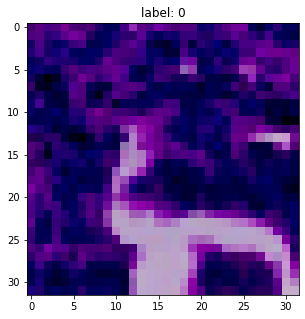

In [74]:
test_path = "../input/cancer-detection/test"
submission_df = pd.read_csv("../input/cancer-detection/sample_submission.csv")

test_img = ImageDataset(df=submission_df, image_dir=test_path, transform=transform)
test_loader = DataLoader(dataset=test_img, batch_size=32, shuffle=False)

image, label = test_img[20]
imshow(image, label)

torch.Size([3, 32, 32])


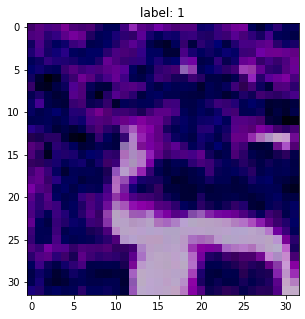

In [75]:
img = image.cuda()
img = img.unsqueeze(0)
output = modified_Resnet(img)
_, preds = torch.max(output.data, 1)
pred = preds.detach().cpu()
pred = int(pred)

imshow(image, pred)

In [73]:
# import math

# modified_Resnet.eval()

# prediction = []
# for batch_i, (data, target) in enumerate(test_loader):
#     img, target = data.cuda(), target.cuda()
#     print(img.shape)
#     output = modified_Resnet(img)
#     _, preds = torch.max(output.data, 1)
#     pred = preds.detach().cpu().numpy()
#     for i in pred:
#         prediction.append(int(i))

# submission_df['label'] = prediction
# submission_df.to_csv("answer")